In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
import seaborn as sns

2024-03-09 17:35:17.739067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 17:35:17.740265: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 17:35:17.758296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 17:35:17.758311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 17:35:17.758814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
import re
# Read in the images data
images = pd.read_csv('../datasets/images_dataset.csv')

# Read in the reports data 
reports = pd.read_csv('../datasets/report_dataset_diseases.csv')

# Merge the images and reports data on the ID column
df = pd.merge(images, reports, on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4707 entries, 0 to 4706
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4707 non-null   int64  
 1   filename        4707 non-null   object 
 2   image_path      4707 non-null   object 
 3   report_file     4707 non-null   object 
 4   body_part       4707 non-null   object 
 5   content         4706 non-null   object 
 6   conclusion      4706 non-null   object 
 7   disease_status  4707 non-null   int64  
 8   disease_type    2912 non-null   object 
 9   location        0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 367.9+ KB


In [3]:
df.head(5)

,id,filename,image_path,report_file,body_part,content,conclusion,disease_status,disease_type,location
0,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,tidak tampak kelainan radiologik.,0,NaN,NaN
1,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,tidak tampak kelainan radiologik.,0,NaN,NaN
2,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,tidak tampak kelainan radiologik.,0,NaN,NaN
3,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN
4,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN


In [4]:
df.drop(columns=["body_part", "filename", "report_file", "content", "conclusion", "disease_type", "location"], inplace=True)
df = df.rename(columns={'id': 'patient_id'})

df.head(5)

,patient_id,image_path,disease_status
0,1,../datasets/radiology_clean/abodemen_3_posisi/...,0
1,1,../datasets/radiology_clean/abodemen_3_posisi/...,0
2,1,../datasets/radiology_clean/abodemen_3_posisi/...,0
3,2,../datasets/radiology_clean/abodemen_3_posisi/...,1
4,2,../datasets/radiology_clean/abodemen_3_posisi/...,1


In [5]:
def show_image_normal(loc):
    img = cv2.imread(df['image_path'].loc[loc])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.imshow(img)
    plt.title(df['image_path'].loc[loc], fontsize=9)
    plt.show()
    print(f"Image path: {df['image_path'].loc[loc]}")

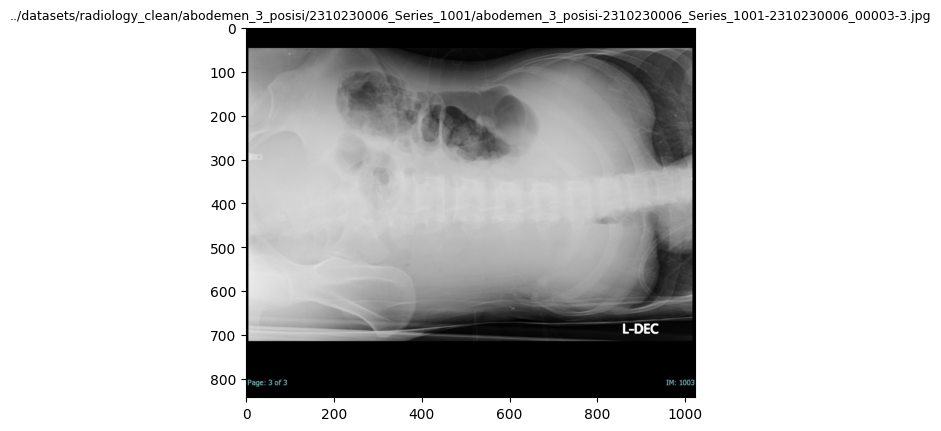

Image path: ../datasets/radiology_clean/abodemen_3_posisi/2310230006_Series_1001/abodemen_3_posisi-2310230006_Series_1001-2310230006_00003-3.jpg


In [6]:
show_image_normal(11)

disease_status
1    2913
0    1794
Name: count, dtype: int64


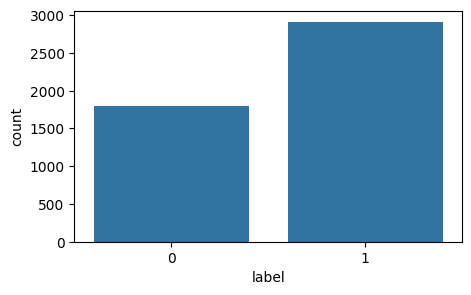

In [7]:
# 1 = disease, 0 = normal
print(df['disease_status'].value_counts())

plt.figure(figsize=(5, 3)) 
sns.countplot(x='disease_status', data=df)
plt.xlabel('label')
plt.ylabel('count')

plt.show()

In [9]:
from keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    return preprocess_input(img_array)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
   
    return image, label

In [10]:
def show_image(data, loc, target_size=(224, 224)):
    img_path = data['image_path'].loc[loc]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_preprocessed = preprocess_image(img_path)
    preprocessed_img_tensor = tf.convert_to_tensor(img_preprocessed, dtype=tf.float32)
    preprocessed_img_tensor = tf.expand_dims(preprocessed_img_tensor, axis=0)  # Add batch dimension

    augmented_img, _ = augment(preprocessed_img_tensor[0], 0)

    # Display the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Display the pre-processed image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 2)
    plt.imshow(img_preprocessed)
    plt.title('Preprocessed Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(augmented_img.numpy())
    plt.title('Augmented Image')
    plt.axis('off')
    
    plt.show()

2024-03-09 17:35:19.038406: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-03-09 17:35:19.038421: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: csbui
2024-03-09 17:35:19.038423: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: csbui
2024-03-09 17:35:19.038484: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-03-09 17:35:19.038493: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-03-09 17:35:19.038495: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in this configuration
Clipping input data to the

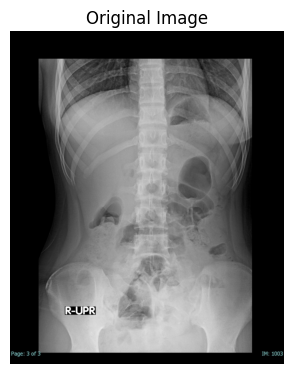

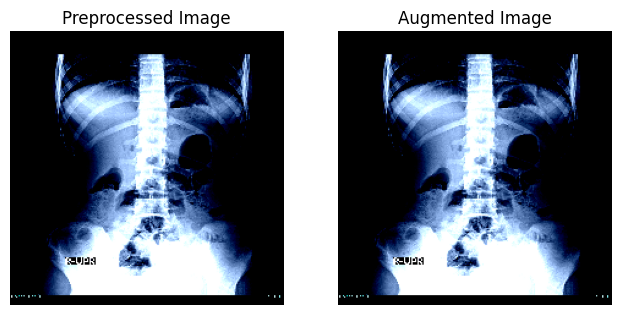

In [11]:
show_image(df, loc=30)

In [12]:
from sklearn.model_selection import train_test_split

BUFFER_SIZE = 2000
BATCH_SIZE = 64

def preprocess_data(data):
    x = []
    y = []
    for _, row in df.iterrows():
        img_path = row['image_path']
        label = row['disease_status']
        
        img = preprocess_image(img_path)

        x.append(img)
        y.append(label)
        
    x = np.array(x)
    y = np.array(y)
    return x, y

X, y = preprocess_data(df)

# Split the preprocessed data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the training and test data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_dataset, test_dataset)

# Count the number of images for each label in the train data
unique, counts = np.unique(y_train, return_counts=True)
train_label_counts = dict(zip(unique, counts))
print("Train data label counts:", train_label_counts)

# Count the number of images for each label in the test data
unique, counts = np.unique(y_test, return_counts=True)
test_label_counts = dict(zip(unique, counts))
print("Test data label counts:", test_label_counts)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Train data label counts: {0: 1445, 1: 2320}
Test data label counts: {0: 349, 1: 593}


In [13]:
import tensorflow as tf
from keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import ResNet50
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import os

base_model = DenseNet121(weights= None, include_top=False, input_shape=(224,224,3))

# Load the weights into the base model
base_model.load_weights('../chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5', by_name=True)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top N layers
N = 10  
for layer in base_model.layers[-N:]:
    layer.trainable = True
    
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [14]:
model = Sequential(
    [
        Input(shape = (224,224,3), name = "input_layer"),
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(1, activation = "sigmoid") # binary classification
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 8088129 (30.85 MB)
Trainable params: 1218753 (4.65 MB)
Non-trainable params: 6869376 (26.20 MB)
____________

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

In [17]:
history = model.fit(train_dataset, epochs = 16, validation_data = test_dataset, callbacks=[early_stop])

Epoch 1/16
59/59 [==============================] - 67s 1s/step - loss: 0.7061 - accuracy: 0.5995 - val_loss: 0.6497 - val_accuracy: 0.6253
Epoch 2/16
59/59 [==============================] - 65s 1s/step - loss: 0.6731 - accuracy: 0.6072 - val_loss: 0.6461 - val_accuracy: 0.6221
Epoch 3/16
59/59 [==============================] - 65s 1s/step - loss: 0.6603 - accuracy: 0.6149 - val_loss: 0.6441 - val_accuracy: 0.6242
Epoch 4/16
59/59 [==============================] - 65s 1s/step - loss: 0.6582 - accuracy: 0.6191 - val_loss: 0.6418 - val_accuracy: 0.6316
Epoch 5/16
59/59 [==============================] - 65s 1s/step - loss: 0.6682 - accuracy: 0.6127 - val_loss: 0.6450 - val_accuracy: 0.6285
Epoch 6/16
59/59 [==============================] - 65s 1s/step - loss: 0.6508 - accuracy: 0.6274 - val_loss: 0.6404 - val_accuracy: 0.6285
Epoch 7/16
59/59 [==============================] - 65s 1s/step - loss: 0.6503 - accuracy: 0.6321 - val_loss: 0.6438 - val_accuracy: 0.6263
Epoch 8/16
59/59 [==

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Convert the predicted probabilities to binary class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

true_labels = y_test  

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test accuracy: {accuracy:.2f}')

# Calculate the ROC-AUC score
auc = roc_auc_score(true_labels, predictions)
print(f'Test ROC-AUC: {auc:.2f}')

15/15 [==============================] - 13s 850ms/step
Test accuracy: 0.65
Test ROC-AUC: 0.62


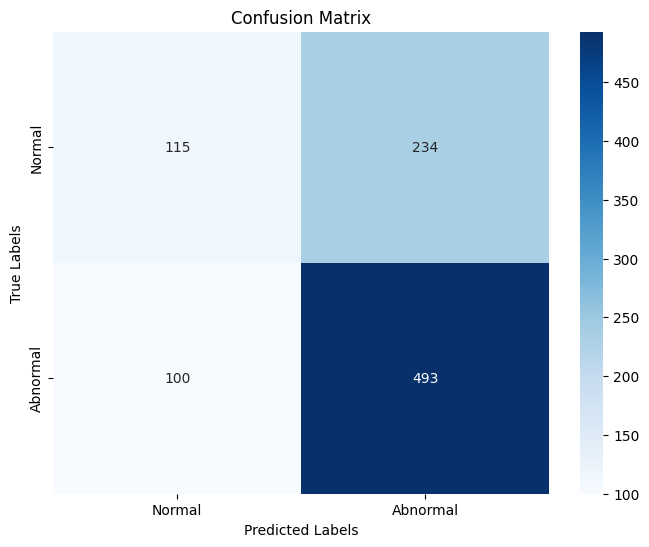

In [19]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
img, true_label = test_dataset.unbatch().take(1).as_numpy_iterator().next()
img_batch = np.expand_dims(img, axis=0)
prediction = model.predict(img_batch)
predicted_label = (prediction > 0.5).astype(int).flatten()[0]

print(f"Predicted label: {predicted_label}, True label: {true_label}")

1/1 [==============================] - 1s 711ms/step
Predicted label: 1, True label: 0
